In [50]:
import pandas as pd
import numpy as np
import os
os.chdir("/Users/karol/Desktop/Antwerp/ai_project")
from candidates_helper import get_rare_customers, bestsellers_age_season, index_preferences, get_discount_hunters, seasonal_customers, age_article_candidates, get_discounted_articles, get_season_articles
from data_reader import load_data_mf, matrix_representation, load_customers_articles, customers_diversification, articles_diversification
from recommenders import recommender_two_towers_final,recommender_two_towers_customer
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from tqdm import tqdm
import torch
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

# Select best models for each customer group

In [2]:
precision_df = pd.read_csv("AI_project/RQ1/evaluation/precision_personalized.csv", index_col="Unnamed: 0")
best_model = list(precision_df.columns[precision_df.loc[x].argmax()]
                  for x in precision_df.index)
best_model = dict(zip(precision_df.index,best_model))
best_model

{'young': 'Shallow/Recent',
 'middle': 'Shallow/Recent',
 'adult': 'Shallow/Personalized',
 'senior': 'Deep/Personalized',
 'mens': 'Shallow/Personalized',
 'ladies': 'Deep/Recent',
 'kids': 'Shallow/Recent',
 'divided': 'Shallow/Recent',
 'sportswear': 'Shallow/Recent',
 'discount': 'Shallow/Personalized',
 'autumn': 'Shallow/Recent',
 'global': 'Deep/Recent'}

# Divide customers

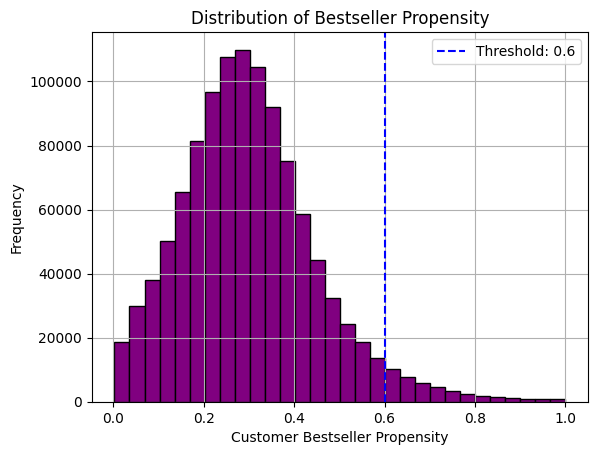

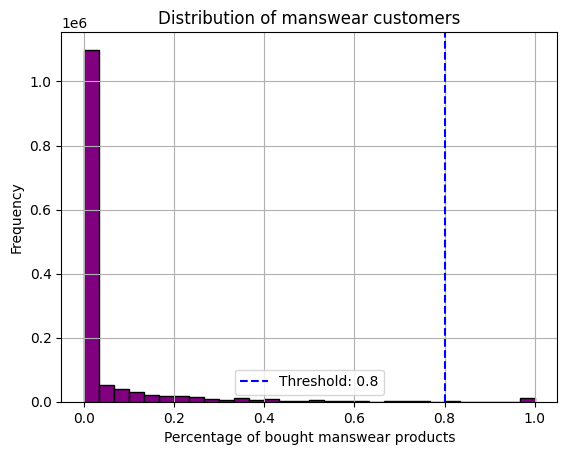

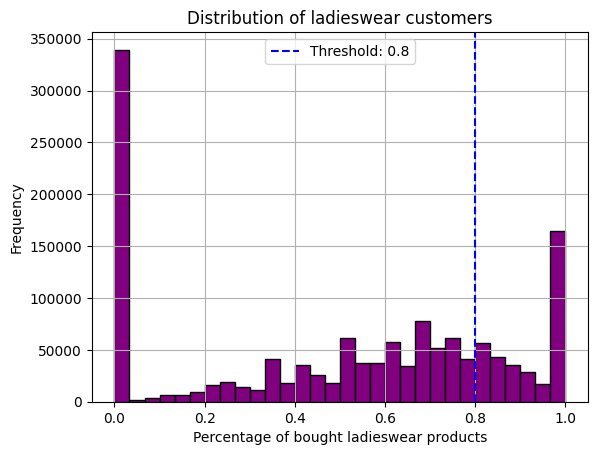

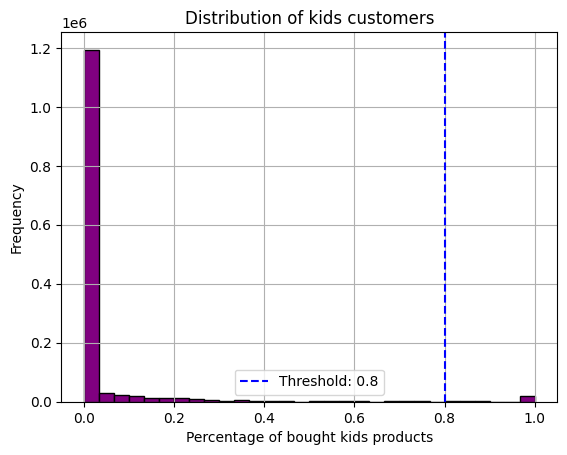

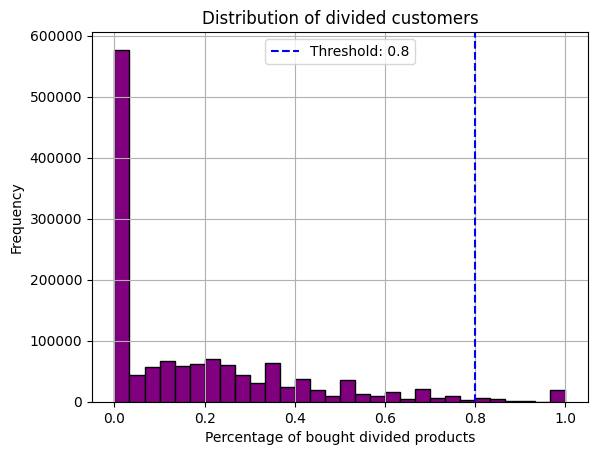

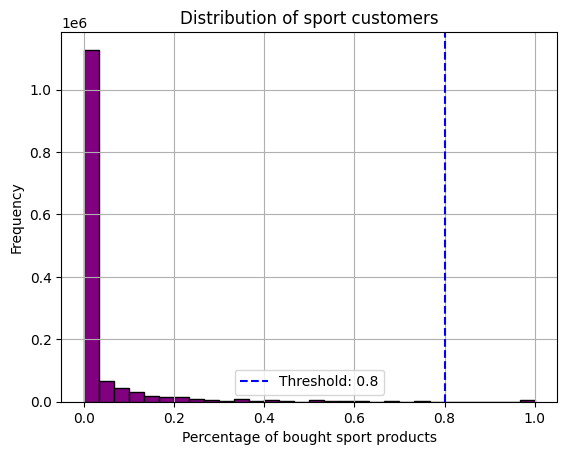

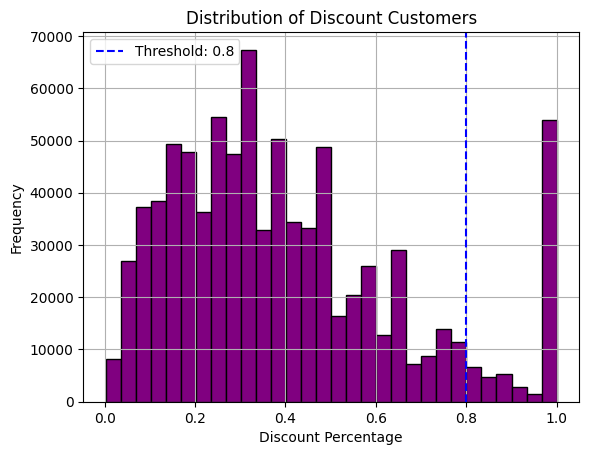

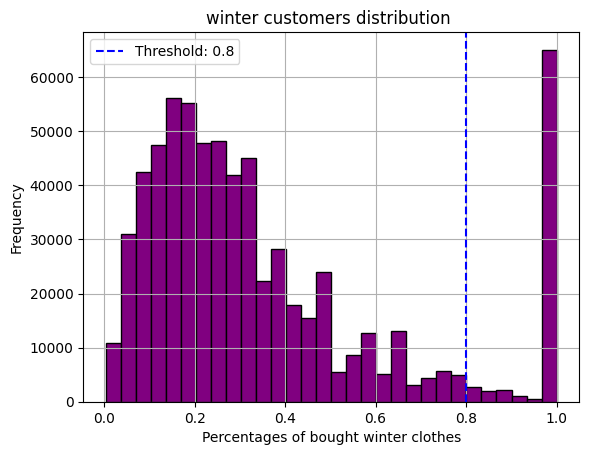

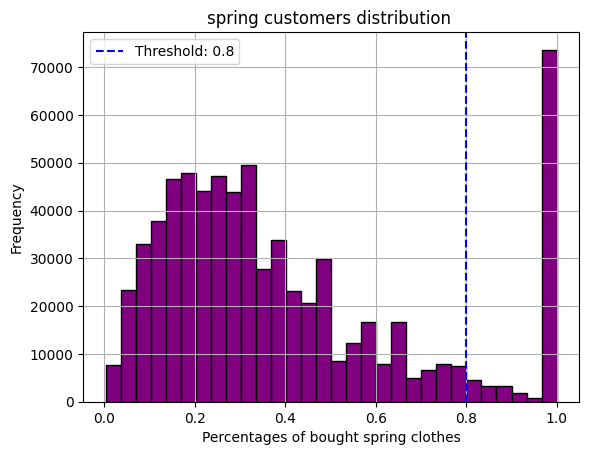

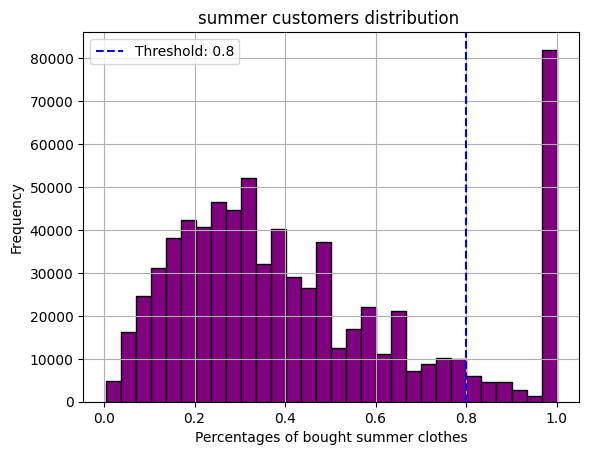

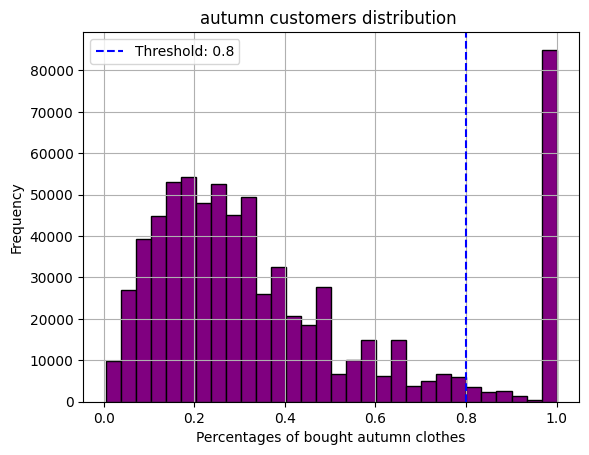

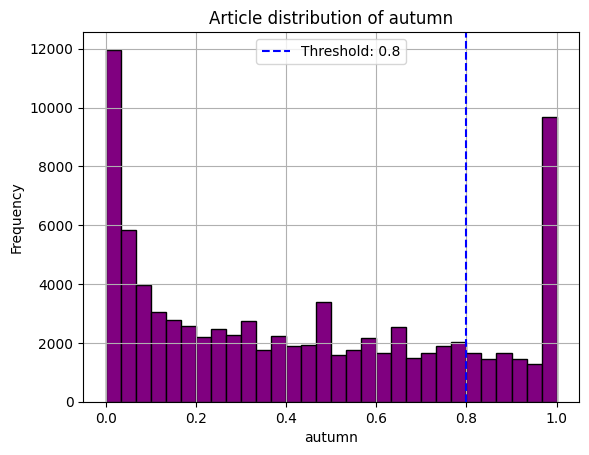

In [3]:
# read customers and transactions data
customers = pd.read_csv("data/preprocessed/customers.csv") 
transactions = pd.read_csv("data/preprocessed/transactions.csv")
articles = pd.read_csv("data/preprocessed/articles.csv") 
transactions_negatives = pd.read_csv("data/preprocessed/transactions_negatives.csv")

last_sold = transactions.groupby("article_id")["t_dat"].max()
articles_recently_sold = last_sold[last_sold > '2020-08-22'].index.tolist()

rare_customers = get_rare_customers(transactions, threshold=3)
bestseller_propensity, all_cust_age_season, age_season_cust = bestsellers_age_season(customers, transactions, rare_customers) 
mens, ladies, kid, div, sport = index_preferences(transactions, articles, customers, rare_customers, set_threshold=0.8)
discount_hunters = get_discount_hunters(transactions, rare_customers)
season_ids = seasonal_customers(transactions, rare_customers)
article_age_indices = age_article_candidates(customers, transactions, date_thershold='2020-08-22', article_threshold=1000)
discounted_articles = get_discounted_articles(transactions, date_threshold='2020-08-22')
season_articles = get_season_articles(transactions, season="autumn", set_threshold=0.8)

all_customer = set(customers.customer_id)
global_customer  = all_customer - set(all_cust_age_season) - set(mens) - set(ladies) - set(kid)\
                - set(div) - set(sport) - set(discount_hunters) - set(season_ids[3]) - set(rare_customers)

# Generate Articles Candidates

In [4]:
# generate article candidates
menswear_articles = list(articles[articles.index_name==3].article_id)
ladieswear_articles = list(articles[articles.index_name.isin([0,1,4])].article_id)
kidswear_articles = list(articles[articles.index_name.isin([2,6,8,9])].article_id)
divide_articles = list(articles[articles.index_name==7].article_id)
sportwear_articles = list(articles[articles.index_name==5].article_id)
young_bestsellers = list(articles[articles.index_name==5].article_id)
# bestsellers from last month
transactions["t_dat"] = pd.to_datetime(transactions["t_dat"])
grouped_counts = transactions[transactions["t_dat"]>="2020-09-01"].groupby("article_id")["customer_id"].count()
bestseller_candidates = list(grouped_counts.sort_values(ascending=False)[0:1000].index)


# Set Up for Recommender

In [5]:
customers_listed = {
    "young": age_season_cust["young_preference"],
    "middle": age_season_cust["middle_aged_preference"],
    "adult": age_season_cust["adult_preferences"],
    "senior": age_season_cust["senior_preference"],
    "mens": mens,
    "ladies": ladies,
    "kids": kid,
    "divided": div,
    "sportswear": sport,
    "discount": discount_hunters,
    "autumn": season_ids[3],
    "global": list(global_customer.union(set(rare_customers)))
}

article_candidates = {
    "young": article_age_indices["young_preference"],
    "middle": article_age_indices["middle_aged_preference"],
    "adult": article_age_indices["adult_preferences"],
    "senior": article_age_indices["senior_preference"],
    "mens": menswear_articles,
    "ladies": ladieswear_articles,
    "kids": kidswear_articles,
    "divided": divide_articles,
    "sportswear": sportwear_articles,
    "discount": discounted_articles,
    "autumn": season_articles,
    "global": bestseller_candidates
}

model_paths = {
    "young": "TwoTowerYoung",
    "middle": "TwoTowerMiddle",
    "adult": "TwoTowerAdult",
    "senior": "TwoTowerSenior",
    "mens": "TwoTowerMens",
    "ladies": "TwoTowerLadies",
    "kids": "TwoTowerKid",
    "divided": "TwoTowerDiv",
    "sportswear": "TwoTowerSport",
    "discount": "TwoTowerDiscount",
    "autumn": "TwoTowerAutumn",
    "global": "TwoTowerGlobal"
}

# Customers sharing multiple groups

In [6]:
intersection_matrix = np.zeros((len(customers_listed), len(customers_listed)))
for x, x_cust in enumerate(customers_listed.values()):
    for y, y_cust in enumerate(customers_listed.values()):
        intersection_count = int(len(set(x_cust).intersection(set(y_cust))))
        intersection_matrix[x,y] = intersection_count

In [48]:
intersection_df = pd.DataFrame(intersection_matrix, columns=article_candidates.keys(), index=article_candidates.keys())
intersection_df = intersection_df.iloc[0:10, 0:10]
np.fill_diagonal(intersection_df.values, 0)
intersection_df

,young,middle,adult,senior,mens,ladies,kids,divided,sportswear,discount
young,0.0,0.0,0.0,0.0,69.0,6364.0,0.0,1541.0,45.0,1884.0
middle,0.0,0.0,0.0,0.0,45.0,4364.0,9.0,703.0,43.0,975.0
adult,0.0,0.0,0.0,0.0,34.0,8538.0,0.0,871.0,221.0,1929.0
senior,0.0,0.0,0.0,0.0,3.0,2856.0,0.0,105.0,1.0,471.0
mens,69.0,45.0,34.0,3.0,0.0,0.0,0.0,0.0,0.0,2924.0
ladies,6364.0,4364.0,8538.0,2856.0,0.0,0.0,0.0,0.0,0.0,28711.0
kids,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3600.0
divided,1541.0,703.0,871.0,105.0,0.0,0.0,0.0,0.0,0.0,4329.0
sportswear,45.0,43.0,221.0,1.0,0.0,0.0,0.0,0.0,0.0,1096.0
discount,1884.0,975.0,1929.0,471.0,2924.0,28711.0,3600.0,4329.0,1096.0,0.0


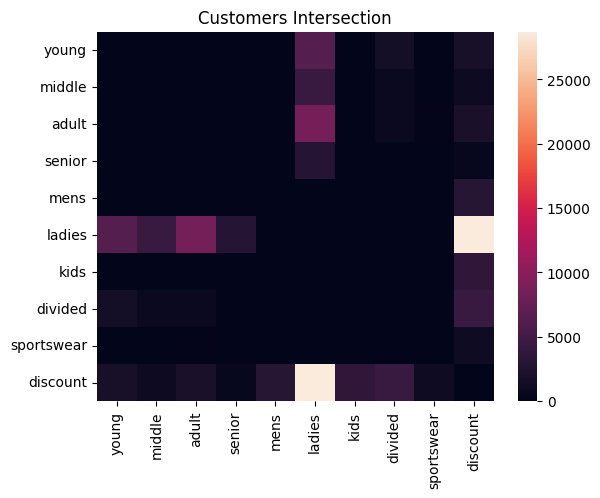

In [52]:
sns.heatmap(intersection_df)
plt.title("Customers Intersection")
plt.show()

# Prioritise Models

In [6]:
sorted_models = np.argsort([precision_df.loc[x].max() for x in precision_df.index])
sorted_models = np.delete(sorted_models,10)
sorted_models = [list(customers_listed.keys())[x] for x in sorted_models]
sorted_models.append("global")
sorted_models

['kids',
 'autumn',
 'discount',
 'mens',
 'middle',
 'sportswear',
 'ladies',
 'young',
 'senior',
 'adult',
 'divided',
 'global']

In [8]:
# generate additional features
articles = articles_diversification(articles, transactions, customers)
customers = customers_diversification(customers, transactions, articles)
transactions_negatives = pd.read_csv("data/preprocessed/transactions_negatives.csv")

# one hot encoding 
articles = articles.set_index("article_id")
customers = customers.set_index("customer_id")

articles_categorical = ["product_type_name","graphical_appearance_name",
                        "perceived_colour_master_name","department_name",
                        "index_name","section_name","garment_group_name"]

articles_cont = ['winter_sale', 'spring_sale','summer_sale', 'autumn_sale',
                'avg_price','young_preference', 'adult_preferences', 
                'middle_aged_preference','senior_preference', 
                'sales_channel_2', 'sales_channel_1']

min_max_cols = ['rank_3_2020', 'rank_4_2020']


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=True), articles_categorical),
        ('cont', 'passthrough', articles_cont),
        ("min_max", MinMaxScaler(), min_max_cols)  # 'passthrough' means no transformation for continuous variables
    ],
    remainder='drop'  # Drop any columns not explicitly transformed
)
articles = csr_matrix(preprocessor.fit_transform(articles))

customers_categorical = ["FN",'Active',"club_member_status", "fashion_news_frequency", "favourite_color", "preferred_garment"]
customers_cont = ["age","first_channel", "second_channel", "avg_price", "amount_purchases","manswear","ladieswear", "kids"]

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=True), customers_categorical),
        ('cont', 'passthrough', customers_cont)  # 'passthrough' means no transformation for continuous variables
    ],
    remainder='drop'  # Drop any columns not explicitly transformed
)
customers = csr_matrix(preprocessor.fit_transform(customers))

AGE GROUP DISTRIBUTION

age_group
adult_preferences         492701
young_preference          357169
middle_aged_preference    339444
senior_preference         182666
Name: count, dtype: int64


/Users/karol/Desktop/Antwerp/ai_project/AI_project/RQ1/data_reader.py:609: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = t.groupby(["article_id", "age_group"])["customer_id"].count()


# Generate Recommendations

In [192]:
final_recommendations = {}
for customer_group in tqdm(sorted_models):
    if best_model[customer_group] in ['Shallow/Recent', 'Shallow/Personalized']:
        TwoTower = torch.load(f"AI_project/RQ1/models/{model_paths[customer_group]}1.pt")
    else:
        TwoTower = torch.load(f"AI_project/RQ1/models/{model_paths[customer_group]}2.pt")
    dataloader_cust, dataloader_art = load_customers_articles(customers, articles, test_customers=customers_listed[customer_group], batch_size=100)
    candidates = [articles_recently_sold]
    
    if best_model[customer_group] in ['Deep/Personalized', 'Shallow/Personalized']:
        candidates.append(article_candidates[customer_group])
    
    if best_model[customer_group] in ['Deep/Personalized', 'Deep/Recent']:
        recommendations = recommender_two_towers_customer(TwoTower, dataloader_cust, dataloader_art, targets=None, restrictions=candidates, evaluate=False, top_k=12)
    else:
        recommendations = recommender_two_towers_final(TwoTower, dataloader_cust, dataloader_art, targets=None, restrictions=candidates, evaluate=False, top_k=12)
    
    final_recommendations.update(dict(zip(customers_listed[customer_group],recommendations.tolist())))

100%|██████████| 12/12 [09:43<00:00, 48.64s/it] 


# Generate Submission

In [209]:
with open('data/preprocessed/customers_decoding.pickle', 'rb') as file:
    customer_dict = pickle.load(file)

with open('data/preprocessed/articles_decoding.pickle', 'rb') as file:
    article_dict = pickle.load(file)

In [222]:
preds = [' '.join(['0' + str(article_dict["article_id"][p]) for p in ps]) for ps in final_recommendations.values()]
submission = pd.DataFrame(zip(final_recommendations.keys(), preds), columns=["customer_id","prediction"])
submission["customer_id"] = submission["customer_id"].apply(lambda x: customer_dict["customer_id"][x])
submission.to_csv("submission/TwoTower/Final_submission.csv.gz", index=False)

# Recommendations without already bought products

In [8]:
final_recommendations = {}
matrix = matrix_representation(transactions, train_test=False)
for customer_group in tqdm(sorted_models):
    if best_model[customer_group] in ['Shallow/Recent', 'Shallow/Personalized']:
        TwoTower = torch.load(f"AI_project/RQ1/models/{model_paths[customer_group]}1.pt")
    else:
        TwoTower = torch.load(f"AI_project/RQ1/models/{model_paths[customer_group]}2.pt")
    dataloader_cust, dataloader_art = load_customers_articles(customers, articles, test_customers=customers_listed[customer_group], batch_size=100)

    group_trans = transactions[transactions.customer_id.isin(customers_listed[customer_group])]
    already_bought = matrix[customers_listed[customer_group]]
    candidates = [articles_recently_sold]
    
    if best_model[customer_group] in ['Deep/Personalized', 'Shallow/Personalized']:
        candidates.append(article_candidates[customer_group])
    
    if best_model[customer_group] in ['Deep/Personalized', 'Deep/Recent']:
        recommendations = recommender_two_towers_customer(TwoTower, dataloader_cust, dataloader_art, targets=already_bought, restrictions=candidates, evaluate=False, top_k=12, exclude_already_bought=True)
    else:
        recommendations = recommender_two_towers_final(TwoTower, dataloader_cust, dataloader_art, targets=already_bought, restrictions=candidates, evaluate=False, top_k=12, exclude_already_bought=True)
    
    final_recommendations.update(dict(zip(customers_listed[customer_group],recommendations.tolist())))

100%|██████████| 12/12 [15:38<00:00, 78.25s/it] 


In [9]:
with open('data/preprocessed/customers_decoding.pickle', 'rb') as file:
    customer_dict = pickle.load(file)

with open('data/preprocessed/articles_decoding.pickle', 'rb') as file:
    article_dict = pickle.load(file)

In [10]:
preds = [' '.join(['0' + str(article_dict["article_id"][p]) for p in ps]) for ps in final_recommendations.values()]
submission = pd.DataFrame(zip(final_recommendations.keys(), preds), columns=["customer_id","prediction"])
submission["customer_id"] = submission["customer_id"].apply(lambda x: customer_dict["customer_id"][x])
submission.to_csv("submission/TwoTower/Final_submission_excluded.csv.gz", index=False)

# Use only Global model

In [12]:
matrix = matrix_representation(transactions, train_test=False)
TwoTower = torch.load(f"AI_project/RQ1/models/TwoTowerGlobal2.pt")
dataloader_cust, dataloader_art = load_customers_articles(customers, articles, batch_size=100)
andidates = [articles_recently_sold]
candidates.append(article_candidates["global"])
recommendations = recommender_two_towers_customer(TwoTower, dataloader_cust, dataloader_art, targets=None, restrictions=candidates, evaluate=False, top_k=12)

In [ ]:
with open('data/preprocessed/customers_decoding.pickle', 'rb') as file:
    customer_dict = pickle.load(file)

with open('data/preprocessed/articles_decoding.pickle', 'rb') as file:
    article_dict = pickle.load(file)

In [14]:
preds = [' '.join(['0' + str(article_dict["article_id"][p.item()]) for p in ps]) for ps in recommendations]
submission = pd.DataFrame(zip(np.arange(len(preds)), preds), columns=["customer_id","prediction"])
submission["customer_id"] = submission["customer_id"].apply(lambda x: customer_dict["customer_id"][x])
submission.to_csv("submission/TwoTower/Final_submission_global.csv.gz", index=False)

# Use Global model for cold start

In [38]:
rare_customers = get_rare_customers(transactions, threshold=3)
TwoTower = torch.load(f"AI_project/RQ1/models/TwoTowerGlobal2.pt")
dataloader_cust, dataloader_art = load_customers_articles(customers, articles, test_customers=rare_customers, batch_size=100)
candidates = [articles_recently_sold]
candidates.append(article_candidates["global"])
recommendations = recommender_two_towers_customer(TwoTower, dataloader_cust, dataloader_art, targets=None, restrictions=candidates, evaluate=False, top_k=12)

In [14]:
with open('data/preprocessed/customers_decoding.pickle', 'rb') as file:
    customer_dict = pickle.load(file)

with open('data/preprocessed/articles_decoding.pickle', 'rb') as file:
    article_dict = pickle.load(file)

In [32]:
preds = [' '.join(['0' + str(article_dict["article_id"][p.item()]) for p in ps]) for ps in recommendations]
submission = pd.DataFrame(zip(np.arange(len(preds)), preds), columns=["customer_id","prediction"])
submission["customer_id"] = submission["customer_id"].apply(lambda x: customer_dict["customer_id"][x])
radek_submission = pd.read_csv("submission/basic_model_submission.csv.gz")
radek_submission[radek_submission["customer_id"].isin(submission["customer_id"])]=submission
radek_submission.to_csv("submission/TwoTower/Final_submission_cold_start.csv.gz", index=False)